## Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV

## Open the data 

In [3]:
adata_full = sc.read_h5ad("/beegfs/home/pmatyskova/singularity/results/scrnaseq/integrated.h5ad")

In [4]:
adata_q = adata_full[adata_full.obs['batch'] == 'Query']
adata_ref = adata_full[adata_full.obs['batch'] == 'Reference']

In [5]:
data_ref_latent = pd.DataFrame(adata_ref.obsm['X_scVI'])
data_ref_labels = pd.DataFrame(adata_ref.obs['C185_named'])
data_ref_labels.index = np.arange(384925)

In [6]:
data_scnew = pd.DataFrame(adata_q.obsm['X_scVI'])

## kNN

### Split data set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_ref_latent, data_ref_labels, test_size=0.2, random_state=1)

### Grid search

In [ ]:
parameters = {"n_neighbors": range(15, 35)} #,"weights": ["uniform", "distance"]
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_ #20, distance

In [ ]:
test_accuracy = gridsearch.score(X_test, y_test) 

In [ ]:
train_accuracy = gridsearch.score(X_train, y_train)

### Apply on full data

In [7]:
knn_model = KNeighborsClassifier(n_neighbors=20, weights="distance")
knn_model.fit(data_ref_latent, data_ref_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=20, weights='distance')

## Predict labels

In [8]:
labels = knn_model.predict(data_scnew)

In [9]:
adata_g_full = sc.read_h5ad("/beegfs/home/pmatyskova/singularity/results/scrnaseq/scrna_preprocessed_full.h5ad")

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata_g_full.obs['C185_named_predicted'] = labels
adata_g_full.uns = adata_q.uns
adata_g_full.obsm = adata_q.obsm

In [12]:
adata_g_full.write("/beegfs/home/pmatyskova/singularity/results/scrnaseq/scrna_preprocessed_labelknn20.h5ad")

### Check the integration

In [13]:
sc.pp.neighbors(adata_full, use_rep="X_scVI")
sc.tl.umap(adata_full)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


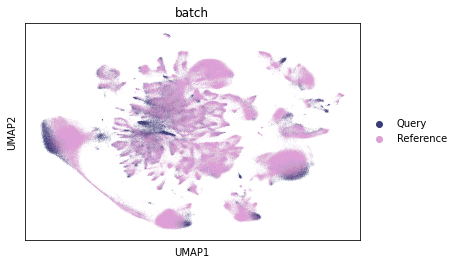

In [15]:
sc.pl.umap(adata_full, color=["batch"], palette='tab20b', save='umap_hypsc.pdf')

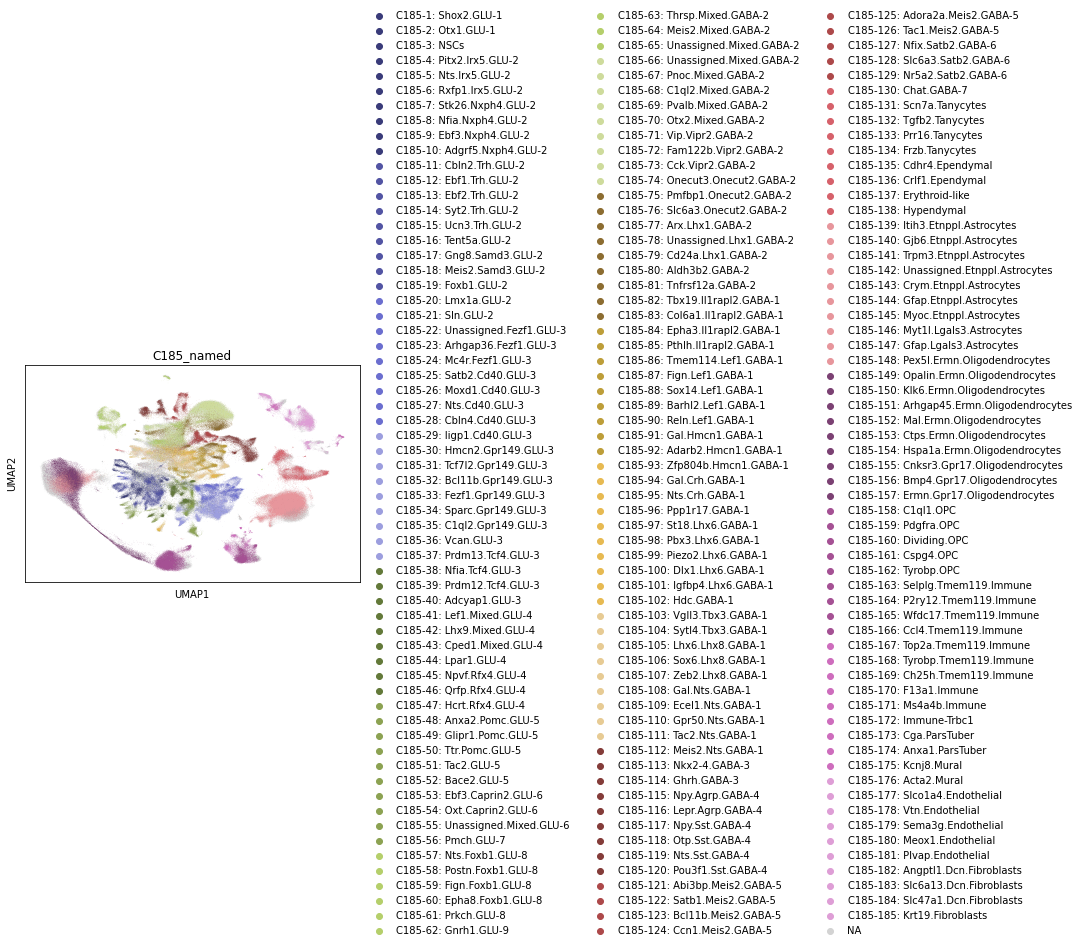

In [15]:
sc.pl.umap(adata_full, color=['C185_named'], palette='tab20b')

In [16]:
sc.pp.neighbors(adata_g_full, use_rep="X_scVI")
sc.tl.umap(adata_g_full)

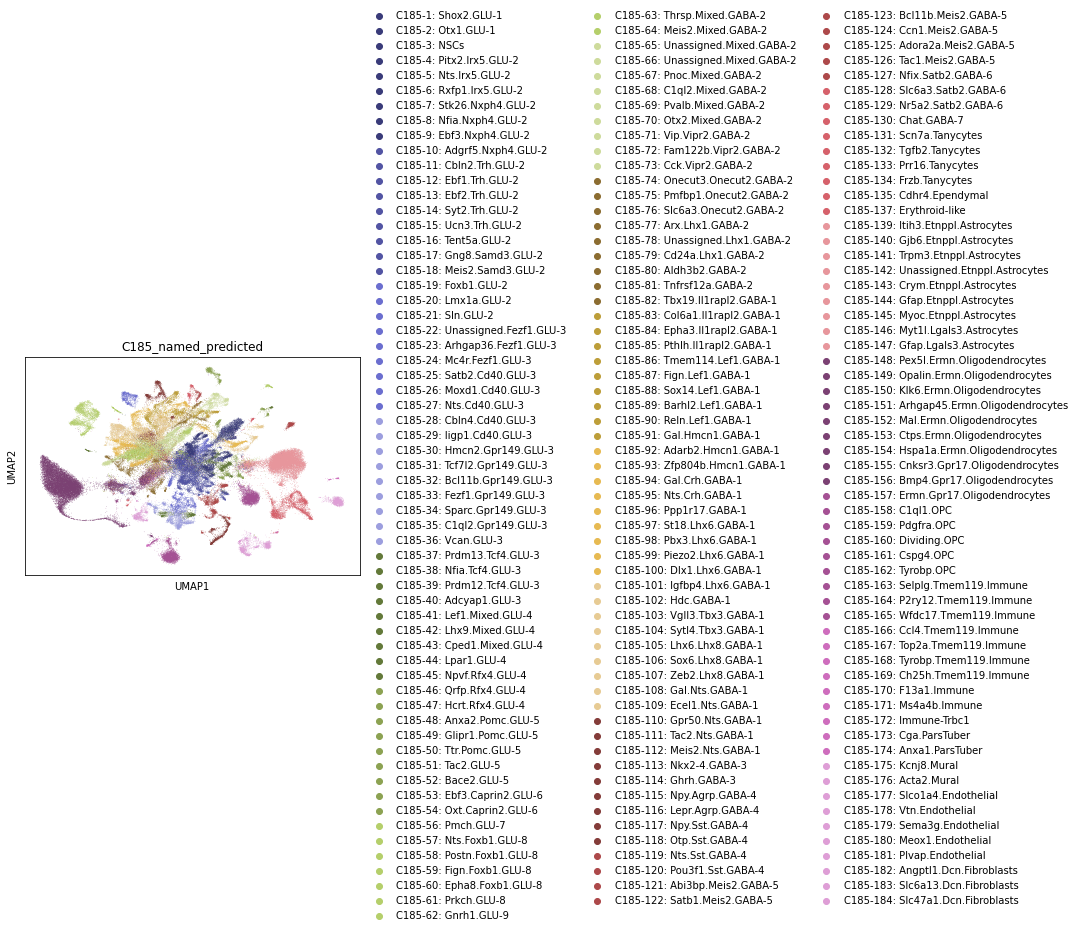

In [17]:
sc.pl.umap(adata_g_full, color=['C185_named_predicted'], palette='tab20b', save='umap_sc.pdf')